In [0]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json
from dataclasses import dataclass, asdict
from typing import Any, List
import joblib
from collections import Counter
import itertools
import seaborn as sns

In [0]:
from dataclasses import dataclass, asdict
from typing import Any, List
import joblib
import pathlib
import msgpack
import gzip


@dataclass
class Player:
    __slots__ = ['account_id',
                 'team',
                 'assists',
                 'deaths',
                 'gold_per_min',
                 'hero_id',
                 'kills',
                 'level',
                 'xp_per_min']

    account_id: Any
    team: Any
    assists: Any
    deaths: Any
    gold_per_min: Any
    hero_id: Any
    kills: Any
    level: Any
    xp_per_min: Any


@dataclass
class PickBan:
    __slots__ = ['hero_id',
                 'is_pick',
                 'order',
                 'team']

    hero_id: Any
    is_pick: Any
    order: Any
    team: Any


@dataclass
class Game:
    __slots__ = ['cluster',
                 'dire_score',
                 'duration',
                 'first_blood_time',
                 'game_mode',
                 'human_players',
                 'lobby_type',
                 'match_id',
                 'match_seq_num',
                 'negative_votes',
                 'picks_bans',
                 'players',
                 'positive_votes',
                 'radiant_score',
                 'radiant_win',
                 'start_time']

    cluster: Any
    dire_score: Any
    duration: Any
    first_blood_time: Any
    game_mode: Any
    human_players: Any
    lobby_type: Any
    match_id: Any
    match_seq_num: Any
    negative_votes: Any
    picks_bans: Any
    players: Any
    positive_votes: Any
    radiant_score: Any
    radiant_win: Any
    start_time: Any

    def __post_init__(self):
        picks_bans = self.picks_bans
        players = self.players

        pb_list = []
        if picks_bans is not None:
            for pb in picks_bans:
                pb_clear = subset_of_dict(pb, PickBan.__slots__)
                pb_list.append(PickBan(**pb_clear))
        pb_list.sort(key=lambda x_pb: x_pb.order)
        self.picks_bans = pb_list

        pl_list = []
        for pl in players:
            if 'team' not in pl.keys():
                pl['team'] = 1 if pl['player_slot'] < 128 else 0
            pl_clear = subset_of_dict(pl, Player.__slots__)
            pl_list.append(Player(**pl_clear))
        self.players = pl_list


def subset_of_dict(dictionary: dict, keys: List[str]) -> dict:
    return {key: dictionary[key] for key in keys if key in dictionary}


def load_games(path: str) -> List[Game]:
    return joblib.load(path)


def dump_games(games: List[Game], path: str) -> None:
    joblib.dump(games, path)


def game_to_dict(game: Game) -> dict:
    return asdict(game)


def dict_to_game(dictionary: dict) -> Game:
    try:
        dictionary_clear = subset_of_dict(dictionary, Game.__slots__)
        new_game = Game(**dictionary_clear)
        return new_game
    except Exception as ex:
        print(dictionary)
        raise ex


def save_to_msgpack(games_list: List[Game], path: str) -> None:
    if not pathlib.Path(path).suffixes:
        path = path + '.msgpack.gz'

    def encode_game(obj):
        if isinstance(obj, Game):
            return {'__game': True, '__data': game_to_dict(obj)}
        return obj

    with gzip.open(path, 'wb') as gz_file:
        msgpack.dump(games_list, gz_file, default=encode_game)


def load_from_msgpack(path: str) -> List[Game]:
    if not pathlib.Path(path).suffixes:
        path = path + '.msgpack.gz'

    def decode_game(obj):
        if '__game' in obj:
            obj = dict_to_game(obj['__data'])
        return obj

    with gzip.open(path, 'rb') as gz_file:
        result = msgpack.load(gz_file, object_hook=decode_game)

    return result

Features extractor

In [0]:
class FeatureExtractor():
  def __init__(self):
    self.radiant_synergy = {'win': Counter(), 'lose': Counter()}
    self.dire_synergy = {'win': Counter(), 'lose': Counter()}

    self.radiant_counter = {'win': Counter(), 'lose': Counter()}
    self.dire_counter = {'win': Counter(), 'lose': Counter()}

    self.radiant=1
    self.dire=0

  def loadAndBuild(self, games):
    for game in games:
      self.addSynergyFromGame(game)
      self.addCounterFromGame(game)


#Synergy

  def addSynergyFromGame(self, game):
    pairs_radiant_heroes, pairs_dire_heroes, radiant_win = self.getPairSynergyPerTeam(game)
    self.addSynegryFromTeams(pairs_radiant_heroes, pairs_dire_heroes, radiant_win)

  def getPairSynergyPerTeam(self, game) -> (List[int], List[int], bool):
    dire_heroes = [ p.hero_id for p in game.players if p.team == self.dire]
    radiant_heroes = [ p.hero_id for p in game.players if p.team == self.radiant]
    pairs_dire_heroes = self.getPairFromTeam(dire_heroes)
    pairs_radiant_heroes = self.getPairFromTeam(radiant_heroes)
    return pairs_radiant_heroes, pairs_dire_heroes, game.radiant_win

  def getPairFromTeam(self,team):
    team.sort()
    return list(itertools.combinations(team,2))

  def addSynegryFromTeams(self, pairs_radiant_heroes, pairs_dire_heroes, radiant_win):
    if radiant_win:
      for pair in pairs_radiant_heroes:
        self.radiant_synergy['win'][pair] += 1
      for pair in pairs_dire_heroes:
        self.dire_synergy['lose'][pair] += 1
    else:
      for pair in pairs_radiant_heroes:
        self.radiant_synergy['lose'][pair] += 1
      for pair in pairs_dire_heroes:
        self.dire_synergy['win'][pair] += 1

#Counter

  def addCounterFromGame(self, game):
    pairs_radiant_heroes, pairs_dire_heroes, radiant_win = self.getPairCounterPerTeam(game)
    self.addCounterFromTeams(pairs_radiant_heroes, pairs_dire_heroes, radiant_win)

  def getPairCounterPerTeam(self, game):
    dire_heroes = [ p.hero_id for p in game.players if p.team == self.dire]
    radiant_heroes = [ p.hero_id for p in game.players if p.team == self.radiant]
    pairs_dire_heroes = self.getCounterPairs(dire_heroes, radiant_heroes)
    pairs_radiant_heroes = self.getCounterPairs(dire_heroes, radiant_heroes)
    return pairs_radiant_heroes, pairs_dire_heroes, game.radiant_win

  def getCounterPairs(self, current_team, enemy_team):
    return list(itertools.product(current_team, enemy_team))

  def addCounterFromTeams(self, pairs_radiant_heroes, pairs_dire_heroes, radiant_win):
    if radiant_win:
      for pair in pairs_radiant_heroes:
        self.radiant_counter['win'][pair] += 1
      for pair in pairs_dire_heroes:
        self.dire_counter['lose'][pair] += 1
    else:
      for pair in pairs_radiant_heroes:
        self.radiant_counter['lose'][pair] += 1
      for pair in pairs_dire_heroes:
        self.dire_counter['win'][pair] += 1

#Calculations

  def getSynergyValuePerPair(self, pair_id: (int,int), is_radiant):
    if is_radiant:
      return self.radiant_synergy['win'][pair_id] / \
      (self.radiant_synergy['win'][pair_id] + \
       self.radiant_synergy['lose'][pair_id] )
    else:
      return self.dire_synergy['win'][pair_id] / \
      (self.dire_synergy['win'][pair_id] + \
       self.dire_synergy['lose'][pair_id] )

  def getSynergyValue(self, team, is_radiant):
    team.sort()
    pairs = list(itertools.combinations(team,2))
    return sum([self.getSynergyValuePerPair(pair,is_radiant) for pair in pairs])


  def getCounterValue(self, current_team, enemy_team, is_radiant_current_team):
    return sum([self.getWinRatioCounterPerHero( \
        hero_id, enemy_team, is_radiant_current_team) \
        for hero_id in current_team])

  def getWinRatioCounterPerHero(self, hero_id, enemy_team, is_radiant):
    pairs = list(itertools.product([hero_id], enemy_team))
    return sum([self.getWinRatioCounterPerPair(pair, is_radiant) for pair in pairs])

  def getWinRatioCounterPerPair(self, pair: (int,int), is_radiant):
    if is_radiant:
      return self.radiant_counter['win'][pair] / \
      (self.radiant_counter['win'][pair] + \
      self.radiant_counter['lose'][pair])
    else:
      return self.dire_counter['win'][pair] / \
      (self.dire_counter['win'][pair] + \
      self.dire_counter['lose'][pair])

#Utils

  def getRadianSynergy(self):
    return self.radiant_synergy

  def getDireSynergy(self):
    return self.dire_synergy

  def getRadianCounter(self):
    return self.dire_counter

  def getDireCounter(self):
    return self.radiant_counter


In [0]:
feature_extractor = joblib.load('drive/My Drive/presonalizacja/new_scap/feature_extractor_full.pkl')

In [0]:
data = load_from_msgpack('drive/My Drive/presonalizacja/new_scap/scrap_merge_full')
feature_extractor = FeatureExtractor()
feature_extractor.loadAndBuild(data)

In [7]:
joblib.dump(feature_extractor, 'drive/My Drive/presonalizacja/new_scap/feature_extractor_full.pkl')

['drive/My Drive/presonalizacja/new_scap/feature_extractor_full.pkl']

In [11]:
#Przyklad synergii
#parametr boolean to 'is_radiant', więc True dla radiant, False dla dire

#Synergia dla całej drużyny 
heroes = np.array([1,99,95,33,5])
print(feature_extractor.getSynergyValue(heroes, True))
print(feature_extractor.getSynergyValue(heroes, False))

#Synergia dla konkretnej pary bohaterów
hero_id_1 = 5
hero_id_2 = 77
pair = (hero_id_1, hero_id_2)
print(feature_extractor.getSynergyValuePerPair(pair,True))
print(feature_extractor.getSynergyValuePerPair(pair,False))

5.554648632640931
4.869525432891158
0.5883180858550316
0.4978165938864629


In [12]:
#Przyklad synergii
#parametr boolean to 'is_radiant', więc True dla radiant, False dla dire

#Synergia dla całej drużyny 
heroes = np.array([1,99,95,33,5])
print(feature_extractor.getSynergyValue(heroes, True))
print(feature_extractor.getSynergyValue(heroes, False))

#Synergia dla konkretnej pary bohaterów
hero_id_1 = 5
hero_id_2 = 77
pair = (hero_id_1, hero_id_2)
print(feature_extractor.getSynergyValuePerPair(pair,True))
print(feature_extractor.getSynergyValuePerPair(pair,False))

5.554648632640931
4.869525432891158
0.5883180858550316
0.4978165938864629


In [13]:
#Przyklad counterpick
#parametr boolean to 'is_radiant', więc True dla radiant, False dla dire lda pierwszej drużyny

#Counterpick dla całych drużyn
team_1 = np.array([1,99,95,33,5])
team_2 = np.array([4,54,12,22,8])

print(feature_extractor.getCounterValue(team_1, team_2, True))
print(feature_extractor.getCounterValue(team_1, team_2, False)) 

#Wartość Counterpick dla pary bohaterów
hero_id_1 = 5
hero_id_2 = 77
pair = (hero_id_1, hero_id_2)
print(feature_extractor.getWinRatioCounterPerPair(pair, True))
print(feature_extractor.getWinRatioCounterPerPair(pair, False)) 

#Wartosc counter pick jednego bohatera wzgledem drugiej calej druzyny
print(feature_extractor.getWinRatioCounterPerHero(hero_id_1, team_2, True))
print(feature_extractor.getWinRatioCounterPerHero(hero_id_1, team_2, False)) 

13.177794139407881
11.822205860592119
0.5439414114513982
0.4560585885486019
2.573933388340555
2.426066611659445


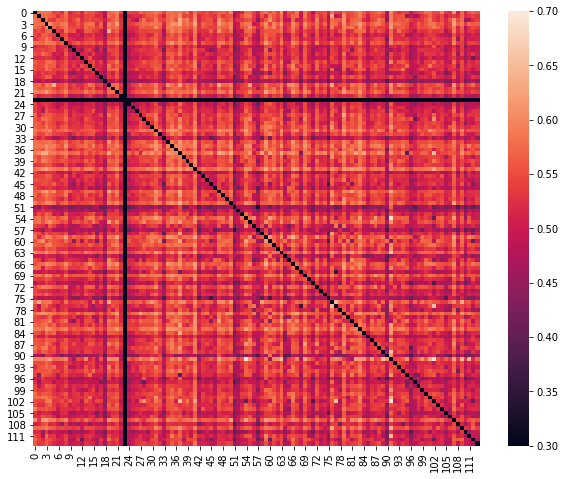

In [21]:
ar = np.zeros((114,114))
for ix,iy in np.ndindex(ar.shape):
    pair = [ix+1,iy+1]
    pair.sort()
    pair = tuple(pair)
    if ix != iy and pair[0]!= 24 and pair[1] != 24:
      ar[ix,iy] = feature_extractor.getSynergyValuePerPair(pair,True)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ar, vmin = 0.3, vmax = 0.7)
plt.savefig('drive/My Drive/presonalizacja/plots/synergy_radiant.png')

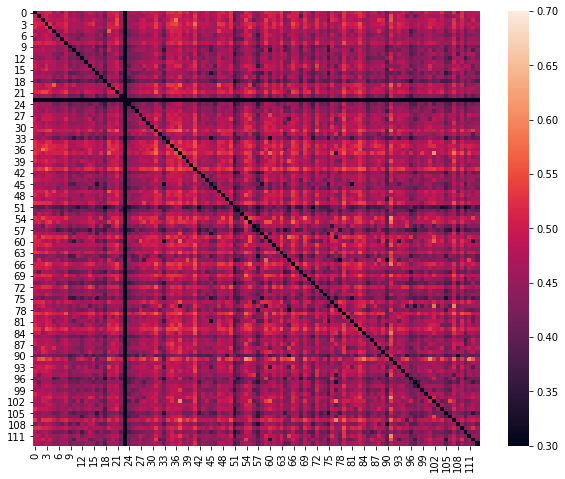

In [15]:
ar = np.zeros((114,114))
for ix,iy in np.ndindex(ar.shape):
    pair = [ix+1,iy+1]
    pair.sort()
    pair = tuple(pair)
    if ix != iy and pair[0]!= 24 and pair[1] != 24:
      ar[ix,iy] = feature_extractor.getSynergyValuePerPair(pair,False)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ar, vmin = 0.3, vmax = 0.7)

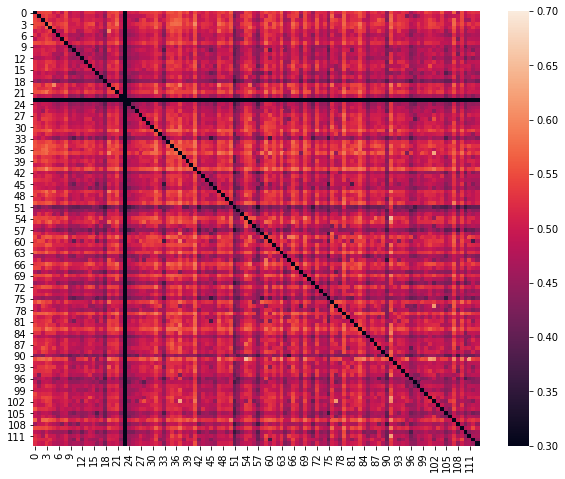

In [16]:
ar = np.zeros((114,114))
for ix,iy in np.ndindex(ar.shape):
    pair = [ix+1,iy+1]
    pair.sort()
    pair = tuple(pair)
    if ix != iy and pair[0]!= 24 and pair[1] != 24:
      ar[ix,iy] = (feature_extractor.getSynergyValuePerPair(pair,False) + feature_extractor.getSynergyValuePerPair(pair,True) ) / 2
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ar, vmin = 0.3, vmax = 0.7)

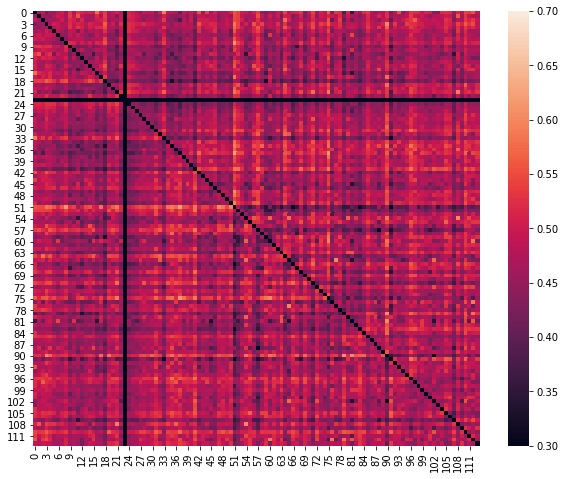

In [17]:
ar = np.zeros((114,114))
for ix,iy in np.ndindex(ar.shape):
    pair = [ix+1,iy+1]
    pair.sort()
    pair = tuple(pair)
    if ix != iy and pair[0]!= 24 and pair[1] != 24:
      ar[ix,iy] = feature_extractor.getWinRatioCounterPerPair(pair,False) 
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ar, vmin = 0.3, vmax = 0.7)

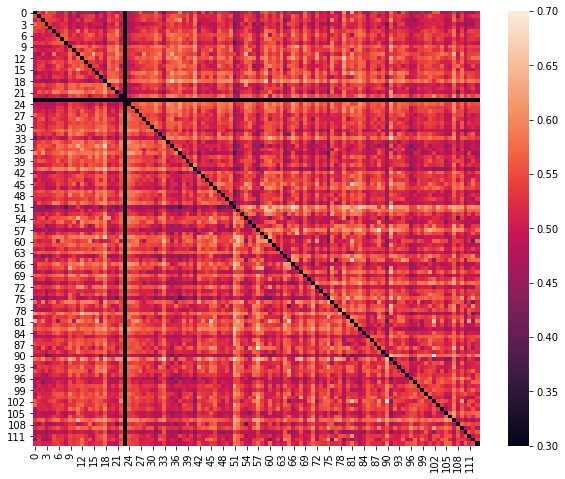

In [18]:
ar = np.zeros((114,114))
for ix,iy in np.ndindex(ar.shape):
    pair = [ix+1,iy+1]
    pair.sort()
    pair = tuple(pair)
    if ix != iy and pair[0]!= 24 and pair[1] != 24:
      ar[ix,iy] = feature_extractor.getWinRatioCounterPerPair(pair,True) 
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ar, vmin = 0.3, vmax = 0.7)

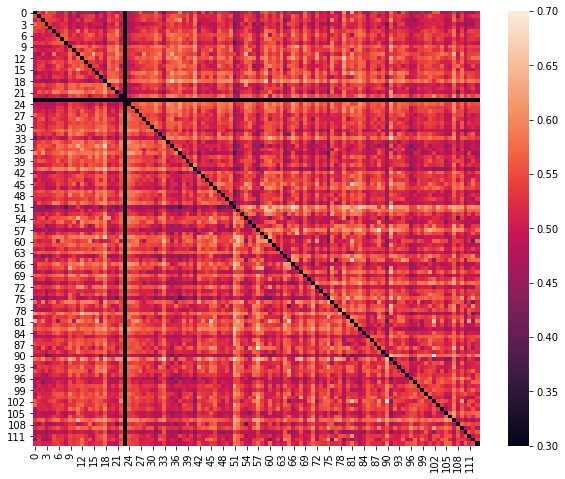

In [19]:
from  matplotlib.colors import LinearSegmentedColormap
ar = np.zeros((114,114))
for ix,iy in np.ndindex(ar.shape):
    pair = [ix+1,iy+1]
    pair.sort()
    pair = tuple(pair)
    if ix != iy and pair[0]!= 24 and pair[1] != 24:
      ar[ix,iy] = (feature_extractor.getWinRatioCounterPerPair(pair,True) + feature_extractor.getWinRatioCounterPerPair(pair,True)  )/2
plt.figure(figsize=(10, 8))
ax = sns.heatmap(ar, vmin = 0.3, vmax = 0.7)